## 개요 ##


- 지도 학습 분류 알고리즘 중 k-NN 사용
- 다항 분류 딥러닝 모델을 제작
- 오차역전파법을 이해하고 딥러닝 가중치 갱신 과정을 파악


# 데이터 개요 ##


- 2017년부터 2021년까지 5년 간 원형 탈모증 등 병적 탈모로 병,의원에서 진료를 받은 국민이 115만 명에 달하는 것으로 나타났다.
- 병적 탈모는 유전이나 노화로 인한 정상 탈모와 달리, 건강 악화나 약 부작용 등으로 인한 탈모를 말한다. 특히 화병, 우울증 같이 스트레스에서 비롯된 경우가 가장 많다
- 400명의 탈모 관련 정보
- 머리숱, 두피압, 커피 섭취량, 스트레스 정도, 수영 여부 등등 정보가 있음.
- 머리숱 정도 : Few, Medium, Many, A lot
- 두피압, 스트레스 : Low, Medium, High, Very High
- 일일 수영 여부, 머리 감기 여부 : Y, N
- 비듬 정도 : None, Few, Many


## 최근접이웃(KNN) ##


- k-NN: 분류하고자 하는 데이터와 가장 가까운 k개의 데이터를 찾아 다수의 클래스쪽으로 분류하는 알고리즘.
- k의 값에 따라 데이터 분류가 달라지기에 상황에 맞는 k값 설정이 필요.
- 다양한 분야에 활용 가능하고 구현이 비교적 간단하여 머신러닝 초보자에게 인기 있는 알고리즘


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# na_filter 매개변수는 결측값이 포함된 행을 제거할지 여부를 지정한다.
# True 로 지정하면 결측값이 포함된 행이 제거되고 False 를 지정하면 결측값을 그대로 표시한다 

df= pd.read_excel("./hair_loss.xlsx", na_filter=False)

df.head()

,hair_loss,stay_up_late,pressure_level,coffee_consumed,brain_working_duration,stress_level,swimming,hair_washing,dandruff
0,Few,2,Low,0,1,Low,No,Y,None
1,Few,0,Low,0,3,Low,No,N,None
2,Medium,3,Low,1,0,Low,Yes,Y,None
3,Few,2,Low,0,1,Low,No,N,None
4,Few,2,Low,0,1,Low,No,Y,None


In [23]:
df.isnull().sum()

hair_loss                 0
stay_up_late              0
pressure_level            0
coffee_consumed           0
brain_working_duration    0
stress_level              0
swimming                  0
hair_washing              0
dandruff                  0
dtype: int64

In [24]:
df.describe() 
# shape 값을 적용하면 튜플됨 

,stay_up_late,coffee_consumed,brain_working_duration
count,400.000000,400.000000,400.000000
mean,1.910000,1.162500,3.970000
std,1.611954,1.978859,4.215272
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,0.000000,2.000000
75%,3.000000,1.000000,7.000000
max,8.000000,10.000000,18.000000


In [25]:
# 각 컬럼별 데이터 개수를 확인
# df.columns

print(df['hair_loss'].value_counts())
# print(df["stay_up_late"].value_counts())
print(df["pressure_level"].value_counts())
# print(df["coffee_consumed"].value_counts())
# print(df["brain_working_duration"].value_counts())
print(df["stress_level"].value_counts())
print(df["swimming"].value_counts())
print(df["hair_washing"].value_counts())
print(df["dandruff"].value_counts())

hair_loss
Few       169
Medium    167
Many       42
A lot      22
Name: count, dtype: int64
pressure_level
Low          275
Medium        57
High          45
Very High     23
Name: count, dtype: int64
stress_level
Low          261
Medium        56
High          45
Very High     38
Name: count, dtype: int64
swimming
No     307
Yes     93
Name: count, dtype: int64
hair_washing
N    209
Y    191
Name: count, dtype: int64
dandruff
None    289
Few      76
Many     35
Name: count, dtype: int64


In [26]:
# 문자로 이루어진 데이터를 숫자로 라벨링한다.
# replace() 함수로 각 문자를 0, 1, 2의 숫자로 대체한다.
# 비듬 정도, 머리숱, 수영 여부, 머리 감기 여부 : 숫자 라벨링
# 남은 두피압과 스트레스 정도는 한 번에 라벨링


# Replace values without inplace=True
df["dandruff"] = df["dandruff"].replace({"None": 0, "Few": 1, "Many": 2})
df["hair_loss"] = df["hair_loss"].replace(
    {"Few": 0, "Medium": 1, "Many": 2, "A lot": 3}
)
df["swimming"] = df["swimming"].replace({"Yes": 1, "No": 0})
df["hair_washing"] = df["hair_washing"].replace({"Y": 1, "N": 0})


# Replace general values for the entire DataFrame
df = df.replace({"Low": 0, "Medium": 1, "High": 2, "Very High": 3})


# Check the first few rows
df.head()


C:\Users\3호실-09\AppData\Local\Temp\ipykernel_16672\2034763613.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["dandruff"] = df["dandruff"].replace({"None": 0, "Few": 1, "Many": 2})
C:\Users\3호실-09\AppData\Local\Temp\ipykernel_16672\2034763613.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["hair_loss"] = df["hair_loss"].replace(
C:\Users\3호실-09\AppData\Local\Temp\ipykernel_16672\2034763613.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old 

,hair_loss,stay_up_late,pressure_level,coffee_consumed,brain_working_duration,stress_level,swimming,hair_washing,dandruff
0,0,2,0,0,1,0,0,1,0
1,0,0,0,0,3,0,0,0,0
2,1,3,0,1,0,0,1,1,0
3,0,2,0,0,1,0,0,0,0
4,0,2,0,0,1,0,0,1,0


In [27]:
# 입력 데이터와 테겟 데이터 분리 
# 머리 숱(hair_loss) 타겟(y), 나머지 데이터는 입력 데이터(X)에 담는다 
X = df.drop('hair_loss', axis=1)
y = df['hair_loss']

X = X.to_numpy()
y= y.to_numpy()

print(X.shape, y.shape)

(400, 8) (400,)


In [28]:
# 훈련 데이터와 테스트 데이터 분리 
# 데이터 양이 적어서 테스트 데이터는 5% 만 지정 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(380, 8) (20, 8) (380,) (20,)


In [29]:
# K 최근접 알고리즘으로 훈련 
# 최근접 이웃점(k)은 3개로 지정 

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

# 모델 훈련 
knn.fit(X_train, y_train)

# 모델 평가 
knn.score(X_train,y_train)

0.9447368421052632

In [30]:
# 테스트 데이터를 이용한 평가 
knn.score(X_test,y_test)

0.85

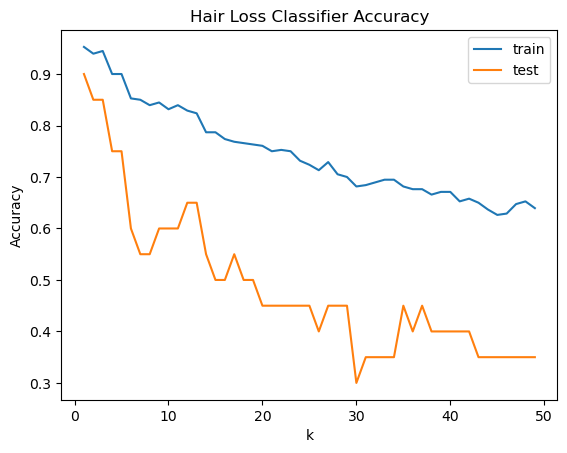

In [31]:
# 평가 지수를 시각화 

# k값에 따라 어떻게 정확도가 바뀌는지 확인


# k_list 변수에 1~50 저장
# 훈련 데이터, 테스트 데이터의 정확도를 저장하기 위해 acc_train, acc_test 생성


# 반복문을 이용해 k-NN모델 선언
# 훈련 데이터로 학습 후 훈련 데이터 정확도와 테스트 데이터 정확도를 각각 저장함


k_list = range(1, 50)
acc_train = []
acc_test = []
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    acc_train.append(classifier.score(X_train, y_train))
    acc_test.append(classifier.score(X_test, y_test))


plt.plot(k_list, acc_train, label="train")
plt.plot(k_list, acc_test, label="test")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Hair Loss Classifier Accuracy")
plt.legend()
plt.show()

# 이웃점이 많아질수록 정확도가 낮아진다. 
# 3개의 지점의 정확도는 약 80% 정도로 평가된다. 

## 다항 분류 딥러닝 모델 ##
- k-NN은 예상보다 높지 않은 정확도가 나왔으므로 다항 분류 딥러닝 모델로 학습.
- 탈모 정도를 네 가지로 나누어 벡터값을 담는다
- 원-핫 인코딩을 해 주어 네 가지 벡터값을 담을 수 있는 리스트로 Y_data를 변환
- 데이터 개수가 많을 때 batch_size가 작으면 학습 시간이 매우 길어진다


In [32]:
# 딥 러닝 훈련을 위한 라이브러리 설치 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
# 원-핫 인코딩
# to_categorical: https://wikidocs.net/193749

from keras.utils import to_categorical

y_encoded = to_categorical(y)
y = np.asarray(y_encoded)
y[0]

array([1., 0., 0., 0.])

In [34]:
# 입력층 1, 은닉층 2개 출력층 1로 딥러닝 모델 구성 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(380, 8) (20, 8) (380, 4) (20, 4)


In [35]:
model = Sequential()
model.add(Dense(72, input_dim=8, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 탈모 정도 카테고리가 4개로 다항이기 떄문에 softmax 

model.summary()

C:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 72)                  │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           2,628 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │             666 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              76 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,018 (15.70 KB)

 Trainable params: 4,018 (15.70 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# 손실률과 정확도 측정 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# 데이터가 적어서 에포크 횟수를 늘려 훈련 정확도를 높인다. 

model.fit(X_train,y_train, epochs=150, batch_size=10,validation_split=0.15)

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2901 - loss: 1.4178 - val_accuracy: 0.4386 - val_loss: 1.2605
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4318 - loss: 1.2595 - val_accuracy: 0.6316 - val_loss: 1.1415
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6173 - loss: 1.1147 - val_accuracy: 0.7368 - val_loss: 0.9668
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6679 - loss: 0.9507 - val_accuracy: 0.7895 - val_loss: 0.8140
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7133 - loss: 0.8208 - val_accuracy: 0.7895 - val_loss: 0.6849
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7819 - loss: 0.6827 - val_accuracy: 0.8772 - val_loss: 0.5474
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7646 - loss: 0.6342 - val_accuracy: 0.8421 - val_loss: 0.4876
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8348 - loss: 0.4763 - val_accuracy: 0.8421 - 

In [41]:
# 테스트 데이터 예측 평가 

model.evaluate(X_test,y_test)

# 정확도가 약 95퍼 최근접 이웃 훈련보다 현격히 개선 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9500 - loss: 0.3068


[0.306796133518219, 0.949999988079071]

In [40]:
# 결과 예측
import numpy as np


# 테스트 데이터에서 10개 샘플 선택
sample_indices = np.random.choice(len(X_test), 10, replace=False)  # 임의로 10개 선택
X_sample = X_test[sample_indices]
Y_sample_actual = y_test[sample_indices]


# 모델 예측
Y_sample_pred = model.predict(X_sample)


# 실제 값과 예측 값을 비교하여 출력
for i, (actual, pred) in enumerate(zip(Y_sample_actual, Y_sample_pred)):
    actual_class = np.argmax(actual)  # 실제 값의 클래스
    predicted_class = np.argmax(pred)  # 예측 값의 클래스
    print(f"Sample {i + 1}:")
    print(f"  Actual: {actual_class}, Predicted: {predicted_class}")
    print(f"  Predicted probabilities: {pred}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Sample 1:
  Actual: 1, Predicted: 1
  Predicted probabilities: [1.6355152e-13 1.0000000e+00 3.2319939e-08 2.7591015e-13]
--------------------------------------------------
Sample 2:
  Actual: 1, Predicted: 1
  Predicted probabilities: [5.3669587e-03 9.9271035e-01 1.6494991e-03 2.7311887e-04]
--------------------------------------------------
Sample 3:
  Actual: 1, Predicted: 1
  Predicted probabilities: [4.4144508e-07 9.9991882e-01 7.8510348e-05 2.2317913e-06]
--------------------------------------------------
Sample 4:
  Actual: 2, Predicted: 2
  Predicted probabilities: [3.9945540e-08 2.5950210e-06 9.9996996e-01 2.7480504e-05]
--------------------------------------------------
Sample 5:
  Actual: 0, Predicted: 0
  Predicted probabilities: [0.9308902  0.05139609 0.00288988 0.01482381]
--------------------------------------------------
Sample 6:
  Actual: 0, Predicted: 0
  Predicted probabilities: [9.9976557e-01 2.3037528e-04 3.2981388e-06 7.264949